# Figure: Output to the oviIN prominence 
1. Connect to neuprint and imports
2. Pull simple connections of the oviINr
3. Filter dataframe for each celltype to find where the oviIN type ranks with each celltype's outputs
4. Plot counts  

This file was written by Rhessa Weber Langstaff based on the hub_spoke_sandbox.ipynb file in the Gutierrez lab github.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuprint import Client
import matplotlib.patheffects as path_effects
from brokenaxes import brokenaxes

from neuprint import fetch_simple_connections, fetch_neurons, NeuronCriteria as NC


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
except:
    np_client = None



In [3]:
# Body Ids of oviINs
oviINr= 423101189
oviINl= 485934965

In [4]:
# inputs to the oviINr
ovi_inputs = fetch_simple_connections(None, oviINr)
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p..."
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {..."
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {..."
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ..."
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {..."
...,...,...,...,...,...,...,...,...
2519,5901221890,423101189,1,SLP422,oviIN,SLP422_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2520,5901226036,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2521,5901230025,423101189,1,None,oviIN,None,oviIN_R,"{'VMNP': {'pre': 1, 'post': 1}, 'VES(R)': {'pr..."
2522,5901231318,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."


In [5]:
# Only use neccessary columns and collapse by celltype in ascending order
ovi_inputs_new = ovi_inputs[['type_pre', 'weight']].groupby('type_pre',as_index=False).sum().sort_values(by='weight', ascending=False, ignore_index=True)

In [6]:
# Filter out the cells with less than 100 synapses
ovi_inputs = ovi_inputs_new[ovi_inputs_new['weight'] >= 100]
ovi_inputs

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290
5,SMP383,281
6,SMP544,259
7,LAL134,247
8,SMP550,234
9,CRE075,225


In [7]:
# Process to fetch connections for each celltype and find out where oviIN ranks in each celltype's outputs
testchunk = ovi_inputs.copy()  # Copies dataframe to avoid SettingWithCopyWarning

# Add columns to testchunk
testchunk['out_to_ovis_weight'] = 0
testchunk['out_to_ovis_rank'] = 0

# iterate through each row in testchunk and fetch connections for each cell type in order to find out where oviIN ranks with each cell's outputs
for idx, row in testchunk.iterrows():
    # fetch outputs for each top input of oviIN
    i_outputs = fetch_simple_connections(row.type_pre,None)

    # grab only necessary columns
    i_outputs = i_outputs[['type_post','weight']]

    # collapse outputs by cell type, summing along weights, and sort in descending order
    i_outputs = i_outputs.groupby('type_post', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

    # grab the row where oviIN is. there will be 1 row for both oviINr and oviINl.
    thing = i_outputs[i_outputs['type_post'] == 'oviIN'].weight

    # add the weight and rank of oviIN in its partners outputs to the testchunk dataframe
    testchunk.loc[idx,'out_to_ovis_weight'] = thing.values[0]
    testchunk.loc[idx,'out_to_ovis_rank'] = thing.index.values[0]


In [97]:
testchunk_edit = testchunk.sort_values(by='out_to_ovis_weight', ascending=False, ignore_index=True)
# Testchunk drop columns
testchunk_small = testchunk_edit[['type_pre', 'out_to_ovis_rank']]
# Pivot so that celltypes in the index, and oviIN ranks in the columns
testchunk_pivot = testchunk_small.pivot(index='out_to_ovis_rank', columns='type_pre', values='out_to_ovis_rank')

# Replace any non-Nan values with the number 1
testchunk_pivot = testchunk_pivot.notnull().astype('int')

# replace any zeros with NaN
testchunk_pivot = testchunk_pivot.replace(0, np.nan)

# Add in a blank row after 7 for plotting purposes
testchunk_pivot.loc[10]= np.nan

# Sort the index
testchunk_pivot = testchunk_pivot.sort_index(ascending=True)

testchunk_pivot

type_pre,CRE075,CRE077,FC2B,FC2C,FS1A,IB017,LAL022,LAL134,OA-VUMa7,SMP007,...,SMP386,SMP520,SMP544,SMP550,SMP551,SMP556,SMP566,VES047,pC1d,pC1e
out_to_ovis_rank,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
import math
# function creates distint colors for each cell type
# Found this on stackoverflow: https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = plt.cm.gist_rainbow(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

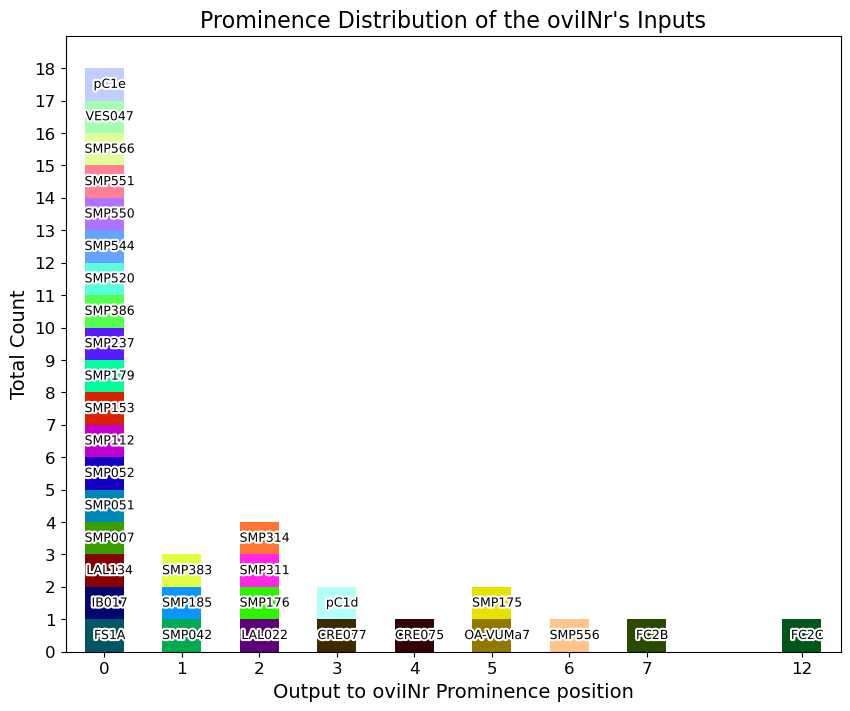

In [128]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color= generate_colormap(len(testchunk_pivot.columns)))

# generate labels for each stacked bar using the cell type names
labels = testchunk_pivot.columns

# annotate the stacked bar plot
for i in range(len(testchunk_pivot)):
    y = 0
    for j in range(len(testchunk_pivot.columns)):
        if testchunk_pivot.iloc[i,j] == 1:
            # annotate with black font and white outline
            ax.text(i+0.07, y + 0.5, labels[j], ha='center', va='center', rotation=0, fontsize=9, color='black', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
            y += 1

# legend off
ax.get_legend().remove()

plt.xticks(rotation=0,fontsize=12)
ax.set_yticks(np.linspace(0, 18, 19))
ax.set_yticklabels(np.linspace(0, 18, 19, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
plt.ylim(0, 19)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)



(0.0, 20.0)

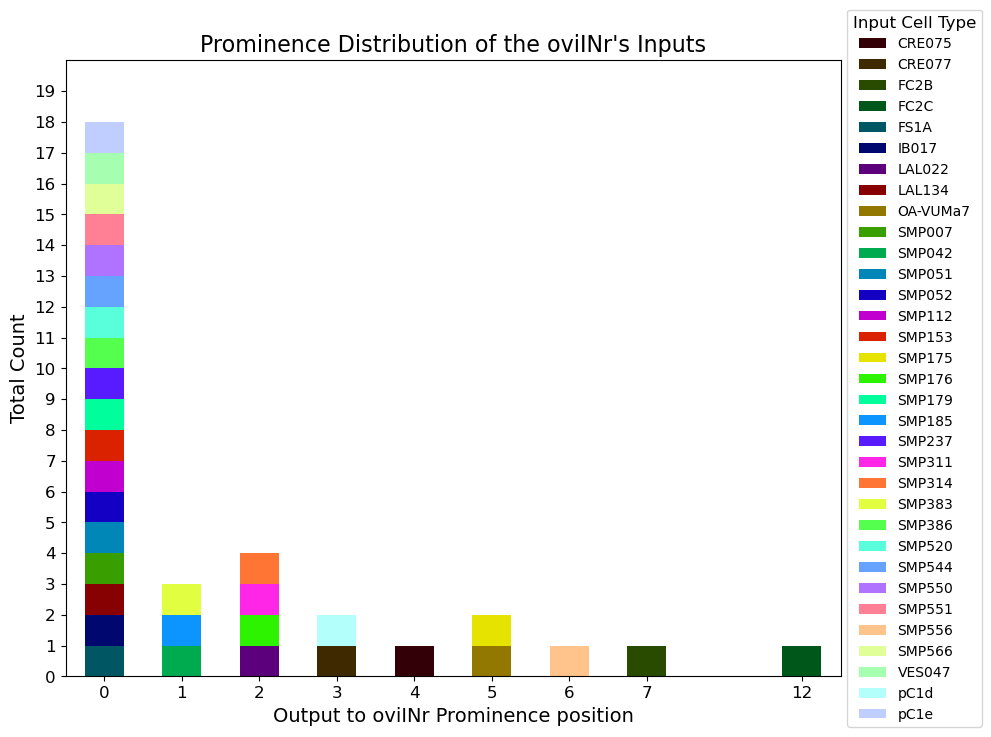

In [157]:
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color= generate_colormap(len(testchunk_pivot.columns)))

# generate labels for each stacked bar using the cell type names
labels = testchunk_pivot.columns
# legend on the right of plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Input Cell Type', title_fontsize='large', fontsize='medium')
plt.xticks(rotation=0,fontsize=12)
# yticks should be 19 of them evenly spaced
ax.set_yticks(np.linspace(0, 19, 20))
ax.set_yticklabels(np.linspace(0, 19, 20, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)
plt.ylim(0, 20)
